Import Libraries and Load Data

In [1]:
# core libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import warnings
warnings.filterwarnings('ignore')

# preprocessing libraries
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix

# statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

# set style for better visualisations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")




Libraries imported successfully!


In [2]:
# load in the dataset
data= 'cleaned_homeloan_dataset.csv'

In [3]:
df= pd.read_csv(data)

In [4]:
df.head(2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146.001808,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N


## 2. EDA-Based Data Quality Assessment

Based on EDA findings, let's assess the specific issues identified 

In [5]:
num_cols= df.select_dtypes(include=[np.number]).columns
num_cols

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

In [6]:
# create a copy for preprocessing 
df_processed = df.copy()

numerical= df_processed[num_cols]

# 1. checking for missing values (EDA showed no missing values)
print("\n1.  Missing Values:")
missing_values = df_processed.isnull().sum()
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("No missing values found (as expected from EDA)")

#2. check for duplicates
print("\n2. Duplicate Rows:")
duplicates = df_processed.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    print(f'Percentage of duplicates: {(duplicates/len(df_processed))* 100:.2sf}%')


# 3. Check skewness for variables identified in EDA as right-skewed
print("\n3. Skewness Analysis (EDA identified right-skewed variables):")    
skewed_vars = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
for var in skewed_vars:
    if var in df_processed.columns:
        skewness = skew(df_processed[var])
        print(f"{var}: skewness = {skewness:.3f} ({'right-skewed' if skewness > 0.5 else 'approximately normal'})")







1.  Missing Values:
No missing values found (as expected from EDA)

2. Duplicate Rows:
Number of duplicate rows: 0

3. Skewness Analysis (EDA identified right-skewed variables):
ApplicantIncome: skewness = 6.850 (right-skewed)
CoapplicantIncome: skewness = 7.402 (right-skewed)
LoanAmount: skewness = 2.524 (right-skewed)


## 3. log-transform skewed variables as recommended by EDA


Based on EDA findings, transform the right-skewed_variables identified

In [7]:
# Log-transform skewed variables as recommended by EDA
print("=== LOG-TRANSFORMING SKEWED VARIABLES ===")
print("EDA identified these variables as right-skewed and recommended log transformation:")

# Variables to log-transform based on EDA findings
skewed_vars = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

for var in skewed_vars:
    if var in df_processed.columns:
        # Check if variable has zero or negative values
        min_val = df_processed[var].min()
        if min_val <= 0:
            # Use log1p for variables with zeros
            df_processed[f'{var}_log'] = np.log1p(df_processed[var])
            print(f"✓ {var}: Applied log1p transformation (had {min_val:.3f} minimum value)")
        else:
            # Use log for positive values only
            df_processed[f'{var}_log'] = np.log1p(df_processed[var])
            print(f"✓ {var}: Applied log transformation")
        
        # Check skewness before and after
        original_skew = skew(df_processed[var])
        transformed_skew = skew(df_processed[f'{var}_log'])
        print(f"  Original skewness: {original_skew:.3f} → Transformed skewness: {transformed_skew:.3f}")

print(f"\nDataset shape after log transformation: {df_processed.shape}")
print("New log-transformed columns:", [col for col in df_processed.columns if '_log' in col])

=== LOG-TRANSFORMING SKEWED VARIABLES ===
EDA identified these variables as right-skewed and recommended log transformation:
✓ ApplicantIncome: Applied log transformation
  Original skewness: 6.850 → Transformed skewness: 0.428
✓ CoapplicantIncome: Applied log1p transformation (had 0.000 minimum value)
  Original skewness: 7.402 → Transformed skewness: -0.176
✓ LoanAmount: Applied log transformation
  Original skewness: 2.524 → Transformed skewness: -0.250

Dataset shape after log transformation: (573, 15)
New log-transformed columns: ['ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log']


# Checking out for outliers found in EDA

In [8]:
num_cols =df.select_dtypes(include=[np.number]).columns
num_cols
for col in num_cols:
    print(f'{col} = {df[col].skew():.3f}"  skewness value')




ApplicantIncome = 6.868"  skewness value
CoapplicantIncome = 7.421"  skewness value
LoanAmount = 2.531"  skewness value
Loan_Amount_Term = -2.425"  skewness value
Credit_History = -2.194"  skewness value


In [9]:

# Outlier treatment based on EDA recommendations
print("=== OUTLIER TREATMENT (IQR-CAPPING METHOD) ===")

# Define numerical columns (excluding target)
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
if 'Loan_Status' in numerical_cols:
    numerical_cols.remove('Loan_Status')

print(f"Treating outliers in {len(numerical_cols)} numerical features...")

# Apply IQR-capping method
outliers_capped = 0
for col in numerical_cols:
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers before capping
    outliers_before = ((df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)).sum()
    
    if outliers_before > 0:
        # Cap outliers
        df_processed[col] = np.where(df_processed[col] < lower_bound, lower_bound, df_processed[col])
        df_processed[col] = np.where(df_processed[col] > upper_bound, upper_bound, df_processed[col])
        outliers_capped += outliers_before
        print(f"✓ {col}: Capped {outliers_before} outliers")

print(f"\nTotal outliers capped: {outliers_capped}")
print(f"Dataset shape after outlier treatment: {df_processed.shape}")

=== OUTLIER TREATMENT (IQR-CAPPING METHOD) ===
Treating outliers in 8 numerical features...
✓ ApplicantIncome: Capped 46 outliers
✓ CoapplicantIncome: Capped 18 outliers
✓ LoanAmount: Capped 38 outliers
✓ Loan_Amount_Term: Capped 82 outliers
✓ Credit_History: Capped 75 outliers
✓ ApplicantIncome_log: Capped 20 outliers
✓ LoanAmount_log: Capped 36 outliers

Total outliers capped: 315
Dataset shape after outlier treatment: (573, 15)


## 4. Feature Engineering

implement the specific feature engineering recommmendations from the EDA report

In [10]:
df_processed.head(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log
0,Male,No,0,Graduate,No,5849.0,0.0,146.001808,360.0,1.0,Urban,Y,8.674197,0.000000,4.990445
1,Male,Yes,1,Graduate,No,4583.0,1508.0,128.000000,360.0,1.0,Rural,N,8.430327,7.319202,4.859812
2,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.000000,360.0,1.0,Urban,Y,8.006701,0.000000,4.204693
3,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.000000,360.0,1.0,Urban,Y,7.857094,7.765993,4.795791
4,Male,No,0,Graduate,No,6000.0,0.0,141.000000,360.0,1.0,Urban,Y,8.699681,0.000000,4.955827


In [11]:
print("FEATURE ENGINEERING BASED ON EDA RECOMMENDATIONS")

eps = 1e-6  # Small constant to avoid divide-by-zero

df_processed['Total_Income'] = df_processed['ApplicantIncome'] + (df_processed['CoapplicantIncome'] )
print("_Total_Income: ApplicantIncome + CpapplicantIncome")
df_processed.head(2)

df_processed['Loan_Income_Ratio'] = df_processed['LoanAmount'] / (df_processed['Total_Income'] )
print("_Loan_Income_Ratio: LoanAmount / Total_Income")
df_processed.head(2)

df_processed['Equated Monthly Installment'] = df_processed['LoanAmount'] / (df_processed['Loan_Amount_Term'] )
print("Equated Monthly Installment: LoanAmount / Loan_Amount_Term")
df_processed.head(2)











FEATURE ENGINEERING BASED ON EDA RECOMMENDATIONS
_Total_Income: ApplicantIncome + CpapplicantIncome
_Loan_Income_Ratio: LoanAmount / Total_Income
Equated Monthly Installment: LoanAmount / Loan_Amount_Term


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Total_Income,Loan_Income_Ratio,Equated Monthly Installment
0,Male,No,0,Graduate,No,5849.0,0.0,146.001808,360.0,1.0,Urban,Y,8.674197,0.000000,4.990445,5849.0,0.024962,0.405561
1,Male,Yes,1,Graduate,No,4583.0,1508.0,128.000000,360.0,1.0,Rural,N,8.430327,7.319202,4.859812,6091.0,0.021015,0.355556


In [12]:
categorical_col= df.select_dtypes(include="object").columns
categorical_col

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area', 'Loan_Status'],
      dtype='object')

Featuring Encoding

In [13]:
# encoding categorical variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le= LabelEncoder()
binary_col= ["Gender", "Married", "Education", "Self_Employed", "Loan_Status"]
for col in binary_col:
    df_processed[col] = le.fit_transform(df_processed[col])
# OneHotEncoding for multi_category



df_processed = pd.get_dummies(df_processed, columns=["Property_Area"], drop_first=True)

df_processed.head()



,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Total_Income,Loan_Income_Ratio,Equated Monthly Installment,Property_Area_Semiurban,Property_Area_Urban
0,1,0,0,0,0,5849.0,0.0,146.001808,360.0,1.0,1,8.674197,0.000000,4.990445,5849.0,0.024962,0.405561,False,True
1,1,1,1,0,0,4583.0,1508.0,128.000000,360.0,1.0,0,8.430327,7.319202,4.859812,6091.0,0.021015,0.355556,False,False
2,1,1,0,0,1,3000.0,0.0,66.000000,360.0,1.0,1,8.006701,0.000000,4.204693,3000.0,0.022000,0.183333,False,True
3,1,1,0,1,0,2583.0,2358.0,120.000000,360.0,1.0,1,7.857094,7.765993,4.795791,4941.0,0.024287,0.333333,False,True
4,1,0,0,0,0,6000.0,0.0,141.000000,360.0,1.0,1,8.699681,0.000000,4.955827,6000.0,0.023500,0.391667,False,True


In [14]:
def correlation_with_target(data, target_col, figsize=(10,2)):
    """
    Plots a heatmap showing correlation of each numeric feature against target_col.
    Returns a series of correlations (sorted by absolute magnitude).
    """
    # Keep only numeric columns
    numeric_df = data.select_dtypes(include='number').copy()
    if target_col not in numeric_df.columns:
        raise ValueError(f"Target column '{target_col}' must be numeric and present in the dataframe.")

    # compute correlations of every numeric column with the target
    corrs = numeric_df.corrwith(numeric_df[target_col]).drop(target_col)

    corrs_df = corrs.to_frame(name='corr').T  # shape (1, n)

    plt.figure(figsize=figsize)
    sns.heatmap(
        corrs_df,
        annot=True,
        fmt=".3f",
        cmap="coolwarm",
        center=0,
        vmin=-1,
        vmax=1,
        cbar_kws={'orientation': 'vertical', 'shrink':0.7}
    )
    plt.xticks(rotation=45, ha='right')
    plt.yticks([0], [target_col], rotation=0)
    plt.title(f'Correlation of numeric features with {target_col}', fontsize=12)
    plt.tight_layout()
    plt.show()

    # return sorted correlations for downstream use
    return corrs.reindex(corrs.abs().sort_values(ascending=False).index)


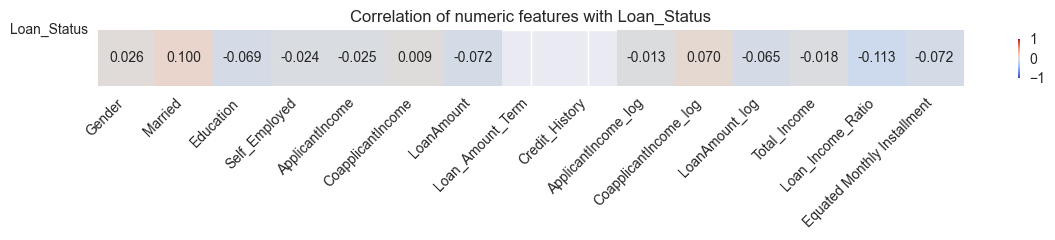

Loan_Income_Ratio             -0.113210
Married                        0.100145
Equated Monthly Installment   -0.071615
LoanAmount                    -0.071615
CoapplicantIncome_log          0.070309
Education                     -0.068610
LoanAmount_log                -0.064819
Gender                         0.025631
ApplicantIncome               -0.025328
Self_Employed                 -0.023527
Total_Income                  -0.018157
ApplicantIncome_log           -0.013386
CoapplicantIncome              0.008829
Loan_Amount_Term                    NaN
Credit_History                      NaN
dtype: float64


In [15]:
corr_series = correlation_with_target(df_processed, 'Loan_Status', figsize=(12,2.5))
print(corr_series) 

### Feature Selection


Based on EDA correlations analysis, select high_signal features and evaluate low-signal ones

In [16]:
# Feature selection based on EDA correlation evidence
print("=== FEATURE SELECTION BASED ON EDA CORRELATION EVIDENCE ===")

# SEPERATE FEATURE AND TARGET
X = df_processed.drop('Loan_Status', axis=1)
Y = df_processed['Loan_Status']

print(f"Total feature available : {X.shape[1]}")


# EDA-identified high-signal features (|correlation| > 0.2)
high_signal_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
print(f"\nEDA-identified high-signal features: {high_signal_features}")

# EDA-identified low-signal features (|correlation| < 0.1) 
low_signal_features = []
print(f"EDA-identified low-signal features: {low_signal_features}")

# Check which features are actually available
available_high_signal = [f for f in high_signal_features if f in X.columns]
available_low_signal = [f for f in low_signal_features if f in X.columns]

print(f"\nAvailable high-signal features: {available_high_signal}")
print(f"Available low-signal features: {available_low_signal}")

# Create feature sets for evaluation
print("\n=== FEATURE SETS FOR EVALUATION ===")

# Set 1: All original features (excluding low-signal)
features_exclude_low_signal = [col for col in X.columns if col not in low_signal_features]
print(f"Set 1 - Exclude low-signal features: {len(features_exclude_low_signal)} features")

# Set 2: High-signal + engineered features
high_signal_plus_engineered = available_high_signal + [col for col in X.columns if any(keyword in col.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log'])]
print(f"Set 2 - High-signal + engineered: {len(high_signal_plus_engineered)} features")

# Set 3: All features (for comparison)
all_features = list(X.columns)
print(f"Set 3 - All features: {len(all_features)} features")

# Let's use Set 2 (high-signal + engineered) as recommended by EDA
selected_features = high_signal_plus_engineered
print(f"\n✓ Selected feature set: {len(selected_features)} features")
print("Selected features:", selected_features)

=== FEATURE SELECTION BASED ON EDA CORRELATION EVIDENCE ===
Total feature available : 18

EDA-identified high-signal features: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
EDA-identified low-signal features: []

Available high-signal features: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
Available low-signal features: []

=== FEATURE SETS FOR EVALUATION ===
Set 1 - Exclude low-signal features: 18 features
Set 2 - High-signal + engineered: 8 features
Set 3 - All features: 18 features

✓ Selected feature set: 8 features
Selected features: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log', 'Total_Income', 'Loan_Income_Ratio']


## Feature Importance Analysis

Analyze the importance of engineered features  based on EDA recommendation

In [17]:
# Feature importance analysis to validate EDA-based engineering
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# CALCULATE CORRELATION WITH TARGET FOR ALL FEATURES
# feature_correlations = X_train_scaled.corrwith(y_train).abs().sort_values(ascending=False)

=== FEATURE IMPORTANCE ANALYSIS ===


Encoding Categorical Variables

In [18]:
# # 4. Check correlation with target (EDA evidence)
# print("\n4. Correlation with Quality (EDA Evidence):")
# correlations = df_processed.corr()['quality'].sort_values(key=abs, ascending=False)
# print("High-signal features (|correlation| > 0.2):")
# high_signal = correlations[abs(correlations) > 0.2].drop('quality')
# for feature, corr in high_signal.items():
#     print(f"  {feature}: {corr:.3f}")

# print("\nLow-signal features (|correlation| < 0.1):")
# low_signal = correlations[abs(correlations) < 0.1]
# for feature, corr in low_signal.items():
#     print(f"  {feature}: {corr:.3f}")

In [19]:
df_processed.isnull().sum()

Gender                         0
Married                        0
Dependents                     0
Education                      0
Self_Employed                  0
ApplicantIncome                0
CoapplicantIncome              0
LoanAmount                     0
Loan_Amount_Term               0
Credit_History                 0
Loan_Status                    0
ApplicantIncome_log            0
CoapplicantIncome_log          0
LoanAmount_log                 0
Total_Income                   0
Loan_Income_Ratio              0
Equated Monthly Installment    0
Property_Area_Semiurban        0
Property_Area_Urban            0
dtype: int64